In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-26 13:02:12.577932


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 64
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(0.7132)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-8.0378)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(37.5248)
train_loss:  -5.607302521836757
valid_loss:  -4.798023958969116
h_min_tilde -6.1621222 ell_tilde -5.445446809263228 kappa_tilde 0.0011812416158816117
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -1.9749295930147173
valid_loss:  -0.13262526643276215
weight_alpha 1.0 h_min_tilde -6.1621222 ell_tilde -1.6064687276983265 kappa_tilde 0.00046851624801682836


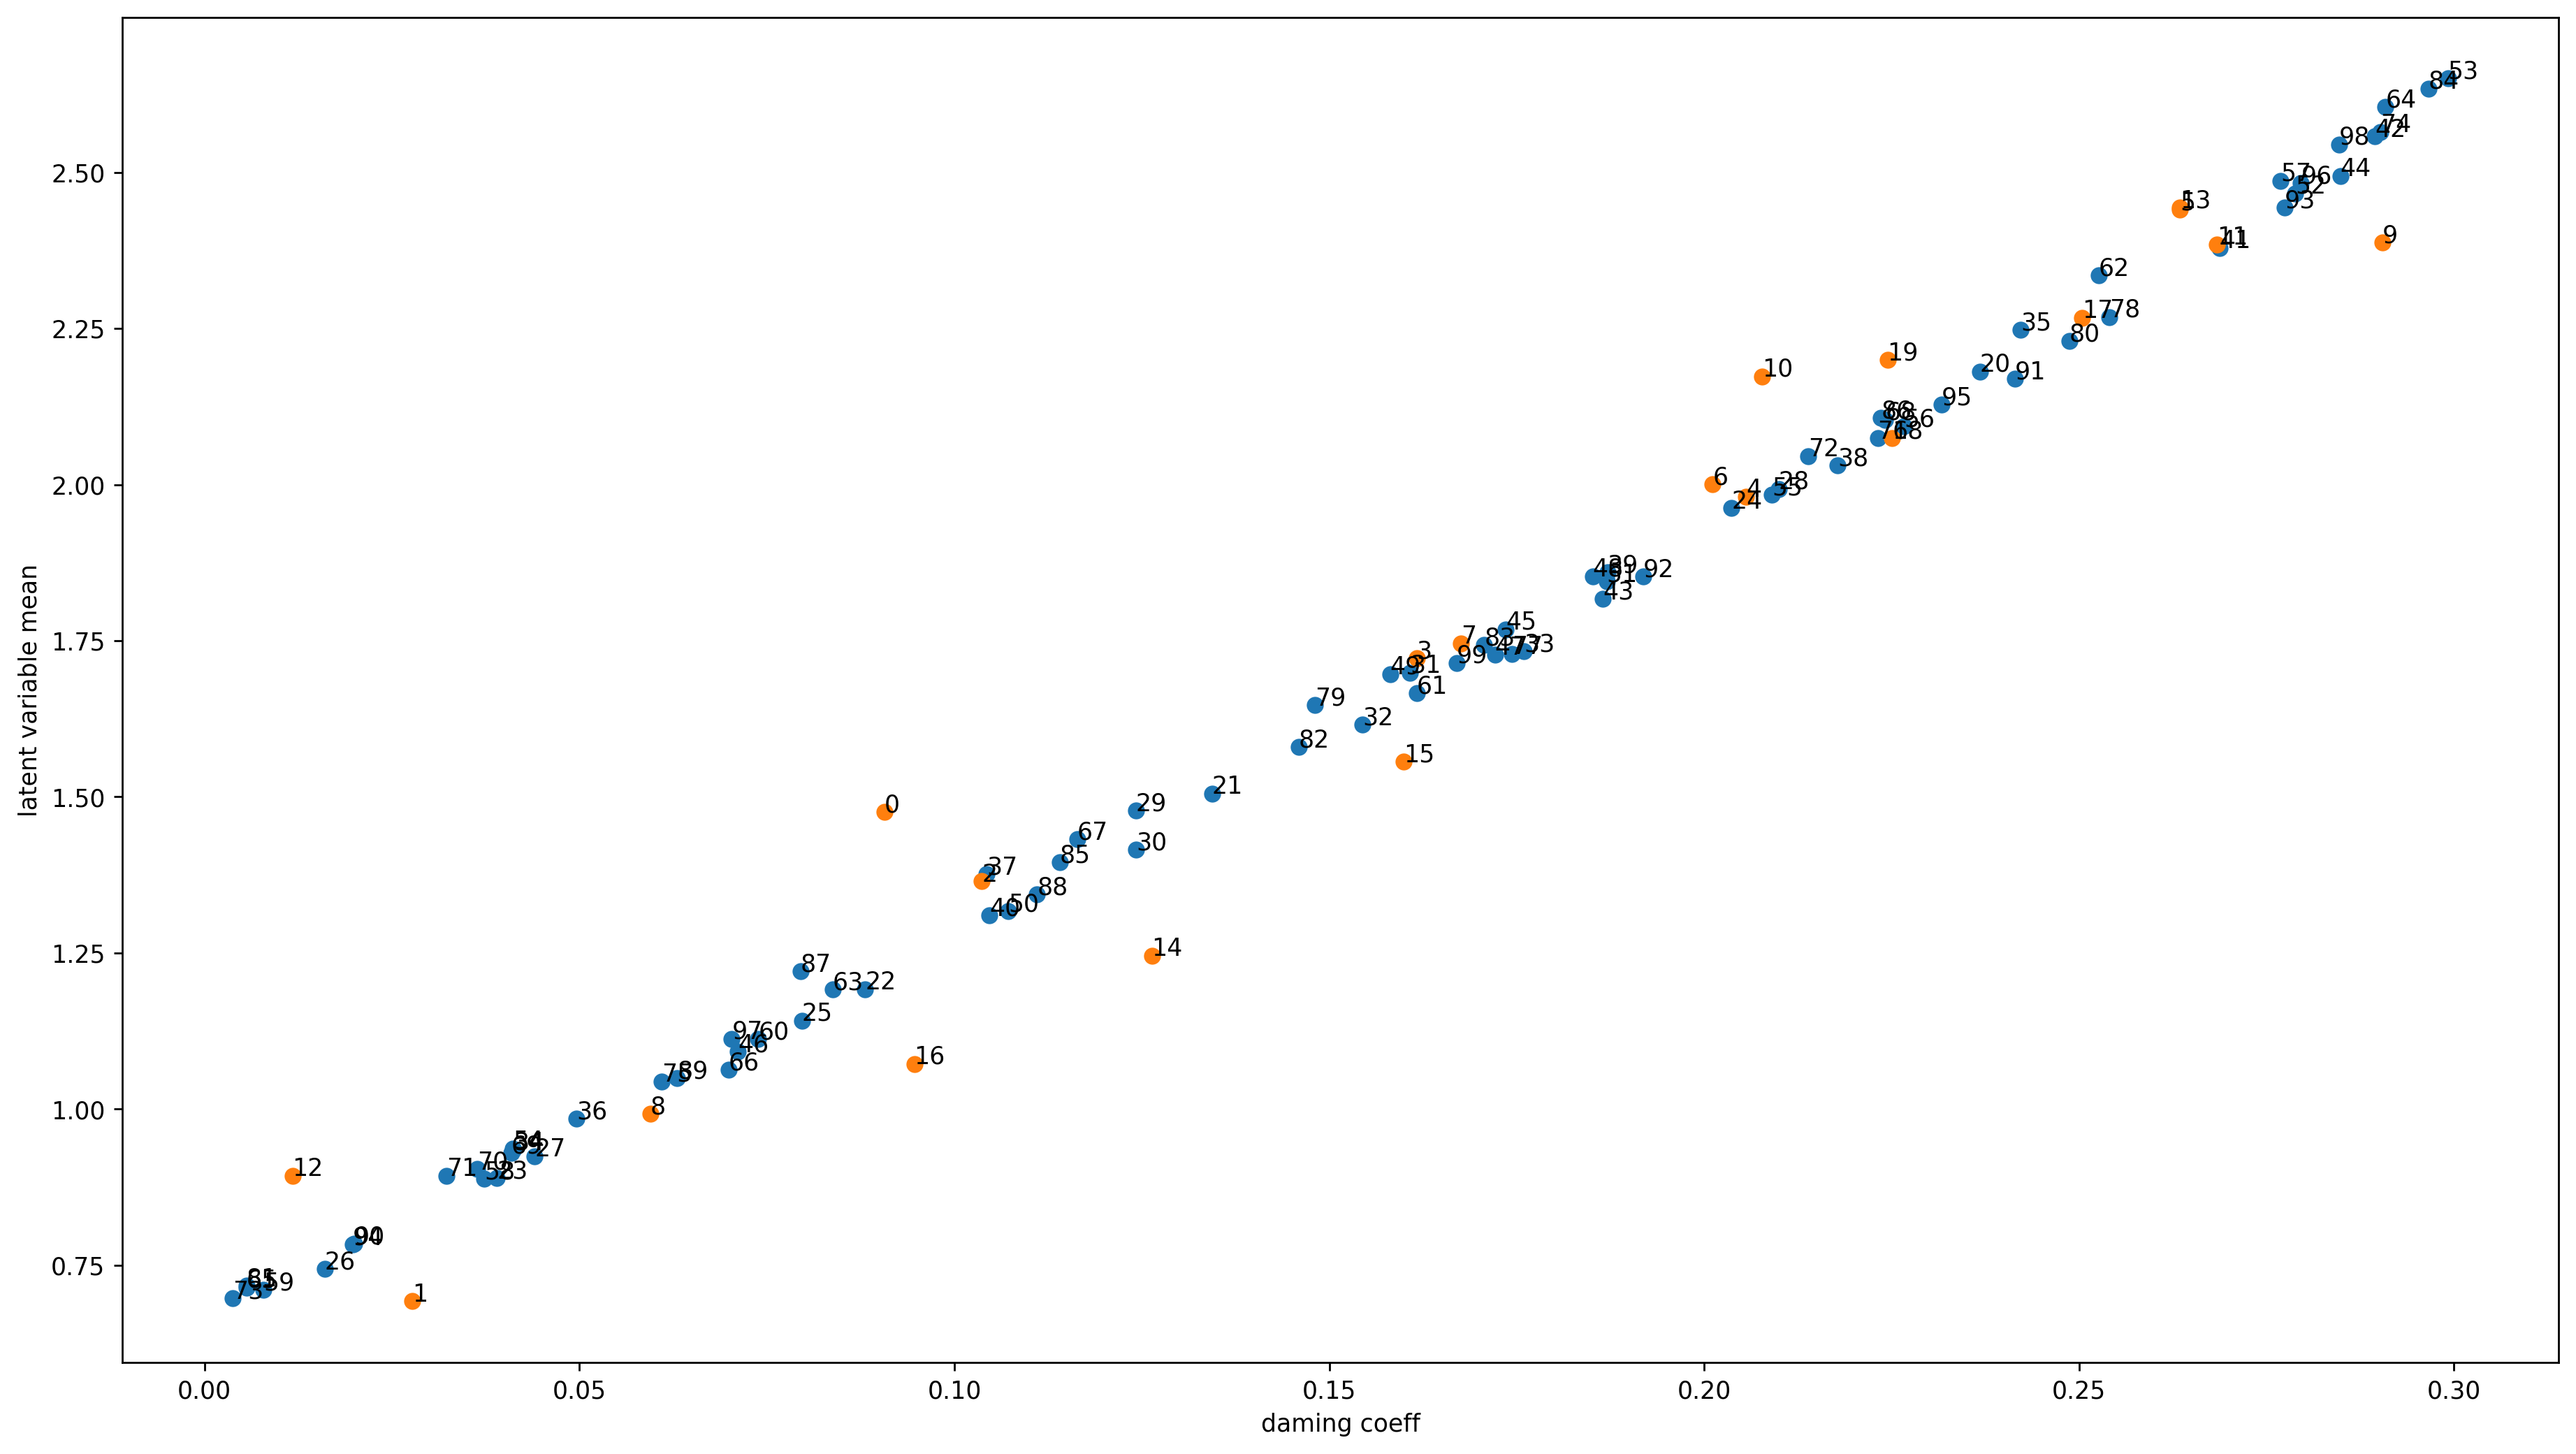

[0.09069977 0.02770158 0.10366822 0.16164502 0.20556585 0.26343523
 0.20114025 0.16760695 0.05943045 0.29047847]
[0.20769678 0.268382   0.01171643 0.26344275 0.12633229 0.15994959
 0.09465469 0.2503877  0.22504329 0.2244497 ]
[0.2367838  0.13436806 0.08808424 0.03900857 0.20365066 0.079664
 0.01600876 0.04401857 0.20992751 0.1242168 ]
[0.12425378 0.16076892 0.15446673 0.17596651 0.04124241 0.24221739
 0.04960626 0.10432976 0.2177994  0.18710166]
[0.1046695  0.26876587 0.28945201 0.18650872 0.28484678 0.17351688
 0.07110809 0.17210385 0.18514347 0.15811743]
[0.10718093 0.18700803 0.27883117 0.29919686 0.04114072 0.20904545
 0.22663892 0.27690736 0.03728129 0.0078633 ]
[0.07386332 0.16164932 0.25260927 0.0837551  0.29087872 0.00559419
 0.06989228 0.11635819 0.22413649 0.04093657]
[0.03640304 0.03224824 0.21389669 0.00376679 0.2901829  0.06098797
 0.22314776 0.17440768 0.25404864 0.14813091]
[0.24869427 0.00557286 0.14590353 0.17065543 0.29658485 0.11404235
 0.22360033 0.07947587 0.111025

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.730995178222656

 2 7.300118684768677

 3 6.9343647956848145

 4 6.810994863510132

 5 3.7727370262145996

 6 3.2503039836883545

 7 3.267306089401245

 8 3.2688751220703125

 9 3.7123944759368896

 10 3.244114637374878

 11 3.2659153938293457

 12 3.343101739883423

 13 3.3915045261383057

 14 3.231905698776245

 15 3.246896982192993

 16 3.926504373550415

 17 3.6330628395080566

 18 3.256392002105713

 19 3.689089775085449

 20 3.3329265117645264

 21 3.494316816329956

 22 3.7277889251708984

 23 3.222266435623169

 24 3.316344976425171

 25 3.167947769165039

 26 3.1242144107818604

 27 3.115429639816284

 28 3.1606714725494385

 29 3.1788625717163086

 30 3.1819028854370117

 31 3.124796152114868

 32 3.21071720123291

 33 3.2033188343048096

 34 3.2108237743377686

 35 3.198124408721924

 36 3.185568332672119

 37 3.1353707313537598

 38 3.2637059688568115

 39 3.160309076309204

 40 3.153869867324829

 41 3.3414716720581055

 42 3.20456862449646

 43 3.288745164871216

 4

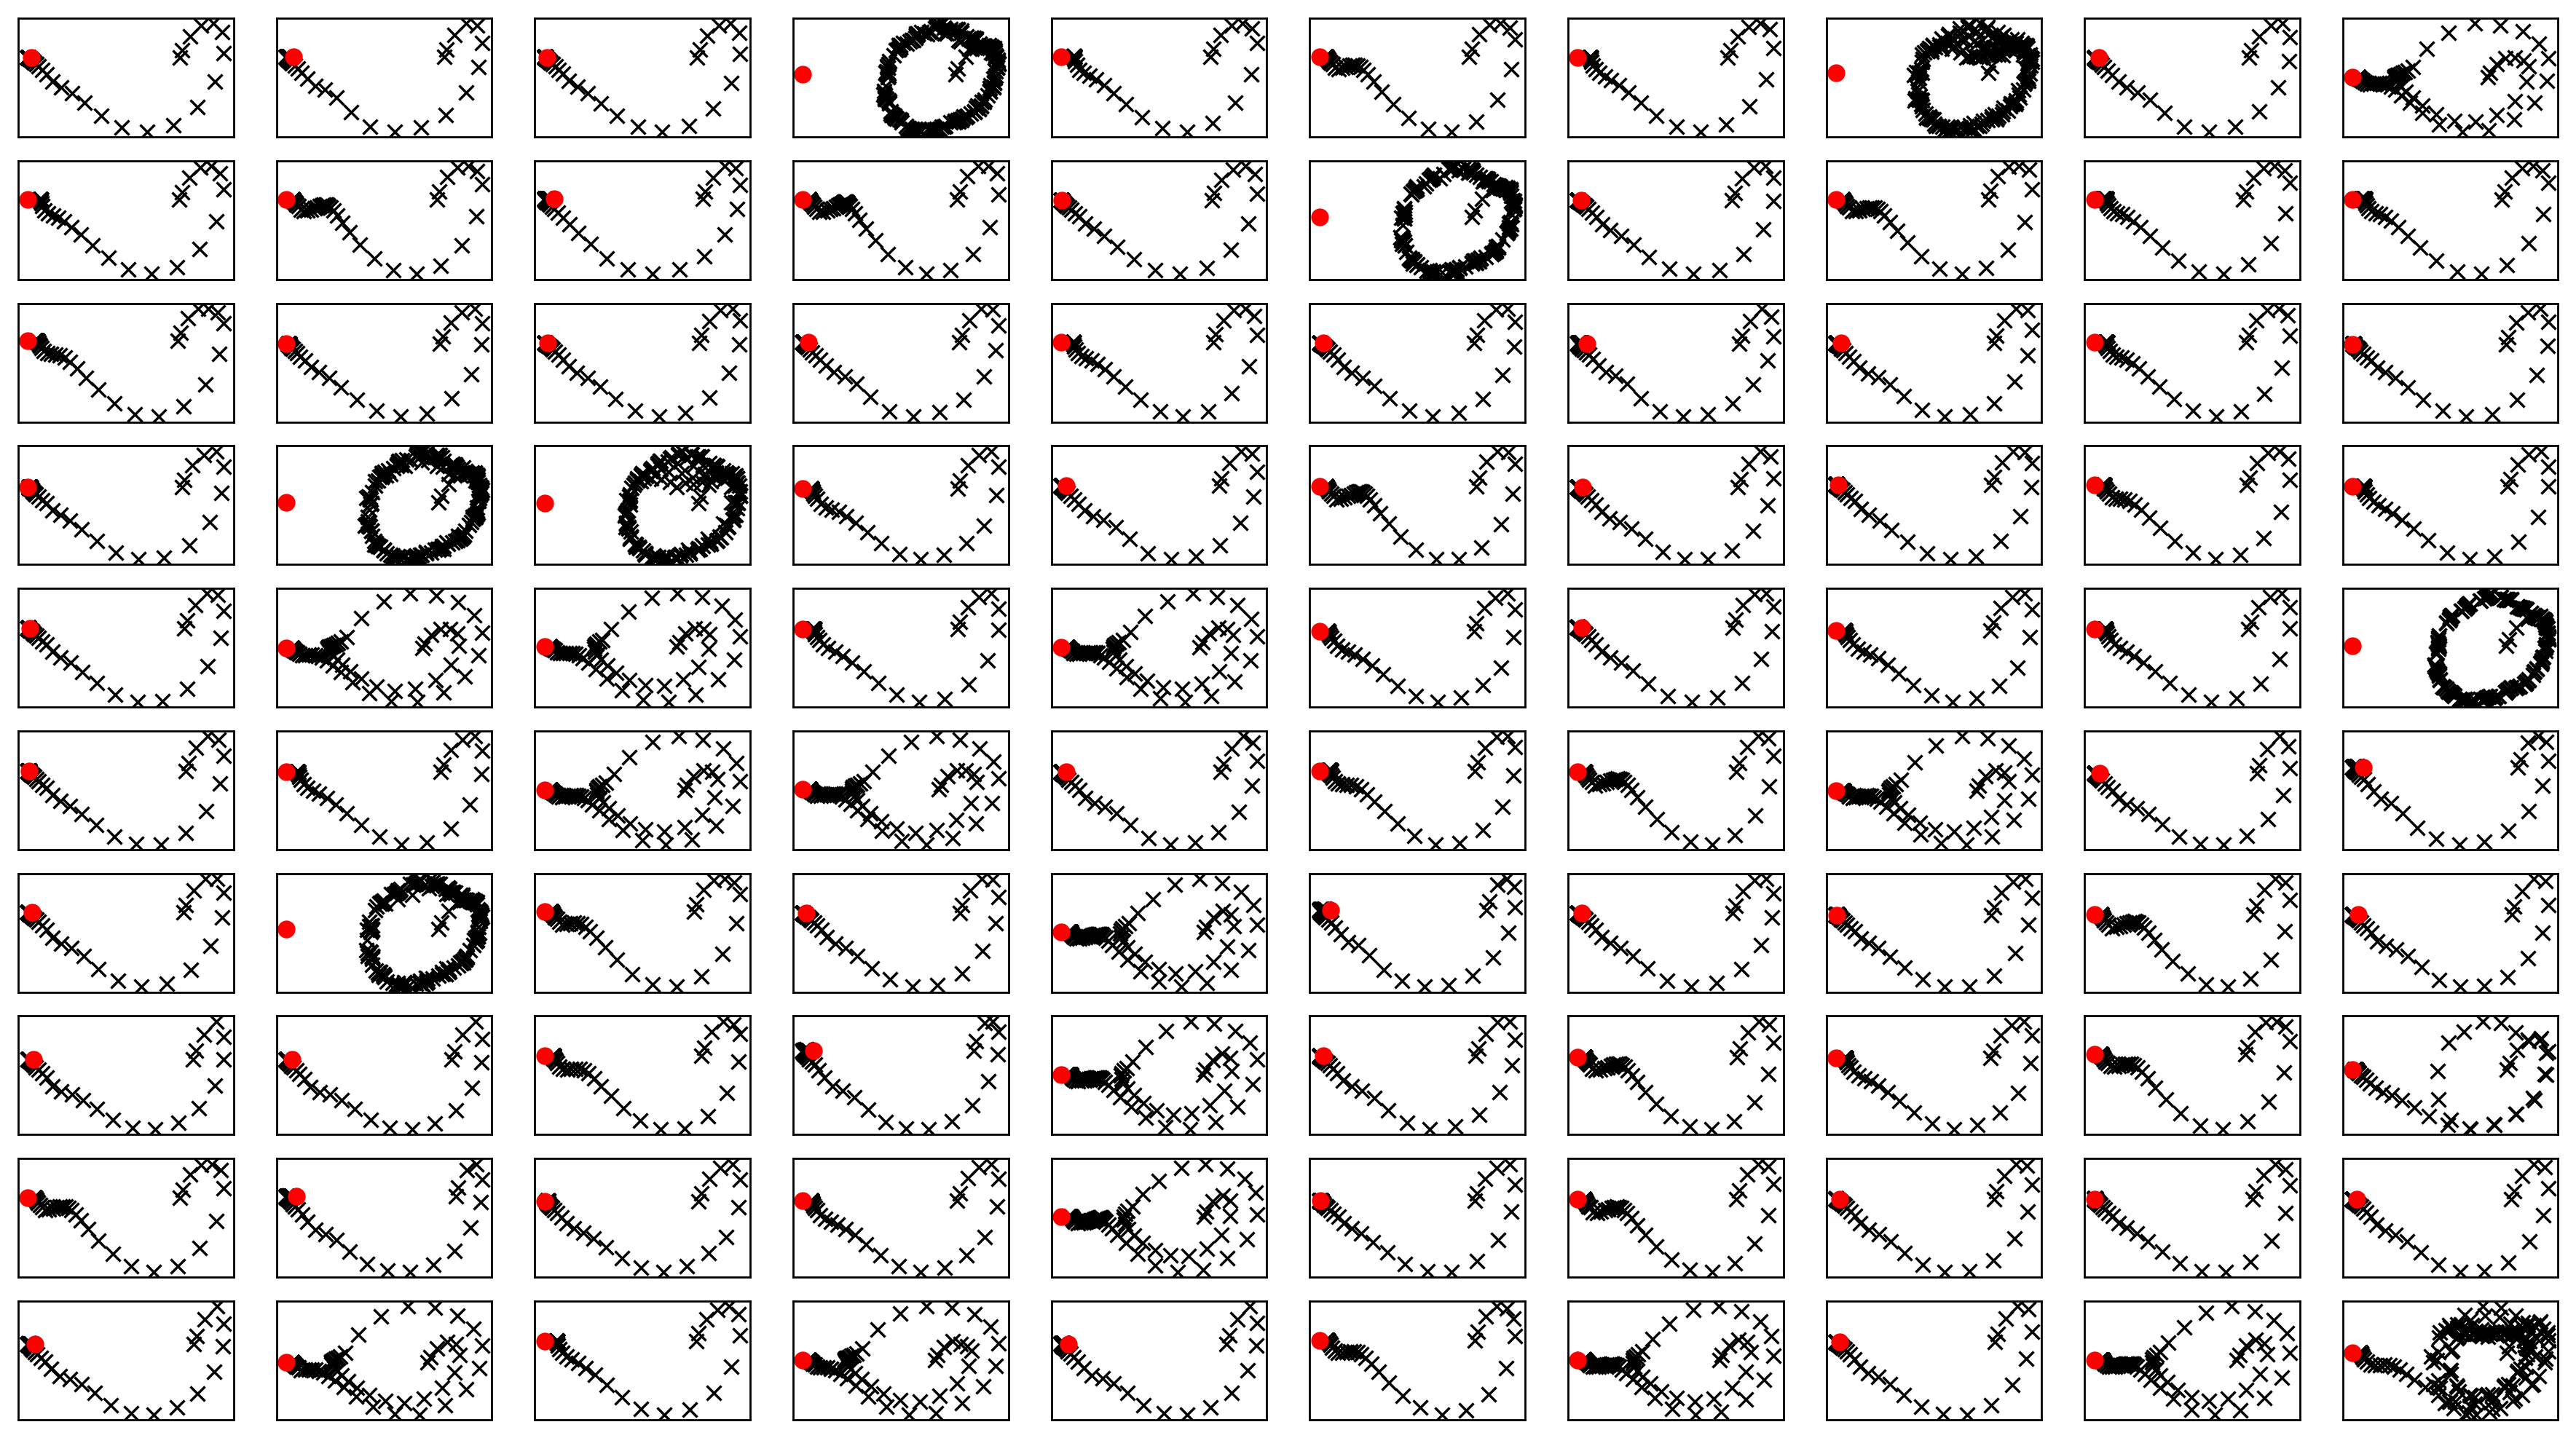

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.2497596740722656

 2 3.18168568611145

 3 3.217879056930542

 4 3.059879779815674

 5 3.1414895057678223

 6 3.2544186115264893

 7 3.172816514968872

 8 2.9951462745666504

 9 3.191640615463257

 10 3.2646191120147705

 11 3.18168306350708

 12 3.241361141204834

 13 3.1192312240600586

 14 3.242008686065674

 15 3.0994977951049805

 16 3.1287970542907715

 17 3.1179215908050537

 18 3.3447556495666504

 19 3.5015997886657715

 20 3.1377737522125244

 21 3.1248857975006104

 22 3.2305197715759277

 23 3.11147141456604

 24 3.0488295555114746

 25 3.154104471206665

 26 3.039423942565918

 27 3.191856861114502

 28 3.1107044219970703

 29 3.128161668777466

 30 3.142775058746338

 31 3.079927921295166

 32 3.157505512237549

 33 3.134645700454712

 34 3.3446695804595947

 35 3.0529372692108154

 36 3.1934022903442383

 37 3.2076005935668945

 38 3.019968271255493

 39 3.1650986671447754

 40 3.2318012714385986

 41 3.157013177871704

 42 3.169749975204467

In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())